In [1]:
#!/usr/bin/env python2
import os
import sys
import argparse
import time

import numpy as np
import random
import theano
import theano.tensor as T
from theano import config
import lasagne
from lasagne.regularization import regularize_network_params
from lasagne.objectives import binary_crossentropy

from iterator import Iterator
import autoencoder_model as ae_model

import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

Using gpu device 0: TITAN X (Pascal) (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/u/larocste/.local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
#Training hyper-parameters

learning_rate = 0.01
weight_decay = 0
num_epochs = 5
max_patience = 100
#data_augmentation={}
SAVEPATH = 'save_models' #might need to change a bit
LOADPATH = 'load_models'
batch_size = 512
extract_center = True
load_caption = False
#nb_discriminator_steps = 2

#Model Hyperparameters
conv_before_pool=[2,2]
n_filters = 32                      
code_size = 1000


#n_units_dense_layer = 10
out_nonlin = lasagne.nonlinearities.sigmoid
_FLOATX = config.floatX


In [3]:
#######################
# Saving path and stuff
######################
exp_name = 'AE'

savepath=os.path.join(sys.path[1],SAVEPATH, exp_name)
loadpath=os.path.join(sys.path[1],LOADPATH, exp_name)

if not os.path.exists(savepath):
    os.makedirs(savepath)
else:
    print('\033[93m The following folder already exists {}. '
          'It will be overwritten in a few seconds...\033[0m'.format(
              savepath))
print 'Saving directory : ' + savepath
print 'Loading directory : '+ loadpath

 The following folder already exists /u/larocste/ift6266_project/save_models/AE. It will be overwritten in a few seconds...
Saving directory : /u/larocste/ift6266_project/save_models/AE
Loading directory : /u/larocste/ift6266_project/load_models/AE


In [4]:
#######################
#Build dataset iterator
#######################

print "Loading training data..." #threads???
train_iter = Iterator(which_set='train', batch_size = batch_size,
            extract_center = extract_center, load_caption = load_caption)

print "Loading validation data..." #threads???
valid_iter = Iterator(which_set='valid', batch_size = batch_size,
            extract_center = extract_center, load_caption = load_caption)

test_iter = None

n_batches_train = train_iter.n_batches
n_batches_valid = valid_iter.n_batches
n_batches_test = test_iter.n_batches if test_iter is not None else 0

print "Batch. train: %d, val %d, test %d" % (n_batches_train,
                            n_batches_valid, n_batches_test)

Loading training data...
Loading validation data...
Batch. train: 161, val 79, test 0


In [5]:
##########################################
# Build generator and discriminator models
##########################################
print('Defining symbolic variables and building models')

#Input and target var for the generator
ae_input_var = T.tensor4('input img bx3x32x32')
ae_target_var = T.tensor4('inpainting target')

print('Building AE model')
ae, last_layer = ae_model.AE_contour2center().build_network(input_var = ae_input_var,
                                              conv_before_pool=conv_before_pool,
                                              n_filters = n_filters,
                                              code_size = code_size)

Defining symbolic variables and building models
Building AE model


In [6]:
##########################################
# Build generator and discriminator models
##########################################



#Print layers and shape (to debug)
print 'AE layers'
for layer in lasagne.layers.get_all_layers(ae):
    print layer, ae[layer].output_shape


AE layers
conv0_0 (None, 32, 64, 64)
bn0_1 (None, 32, 64, 64)
last_layer (None, 3, 32, 32)
dense_up (None, 16384)
bn0_0 (None, 32, 64, 64)
upconv1_0 (None, 64, 32, 32)
bn1_0 (None, 64, 32, 32)
conv0_1 (None, 32, 64, 64)
reshape_enc (None, 16384)
upscale1 (None, 64, 32, 32)
upconv1_1 (None, 64, 32, 32)
bn1_1 (None, 64, 32, 32)
reshape_dec (None, 64, 16, 16)
code_dense (None, 1000)
conv1_0 (None, 64, 32, 32)
conv1_1 (None, 64, 32, 32)
input (None, 3, 64, 64)
pool1 (None, 64, 16, 16)
pool0 (None, 32, 32, 32)


In [7]:
#####################################
# Define and compile theano functions
#####################################
print "Defining and compiling theano functions"
pred_img = lasagne.layers.get_output(ae[last_layer])

ae_loss = T.mean(lasagne.objectives.squared_error(pred_img, ae_target_var))
#TODO : weight decay
# if weight_decay > 0:
#     weightsl2 = regularize_network_params(
#         ae, lasagne.regularization.l2)
#     ae_loss += weight_decay * weightsl2


ae_params = lasagne.layers.get_all_params(ae[last_layer], trainable=True)
ae_updates = lasagne.updates.adam(ae_loss, ae_params, learning_rate = learning_rate)
#discr_acc = $dicriminator accuracy
ae_train_fn = theano.function([ae_input_var,ae_target_var], ae_loss, updates = ae_updates,
                            allow_input_downcast=True)

print 'Done'



Defining and compiling theano functions
Done


In [8]:
get_imgs = theano.function([ae_input_var], lasagne.layers.get_output(ae[last_layer],deterministic = True),
                          allow_input_downcast=True)

(399, 64, 64, 3)
(399, 32, 32, 3)


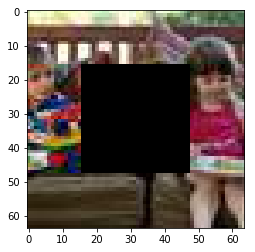

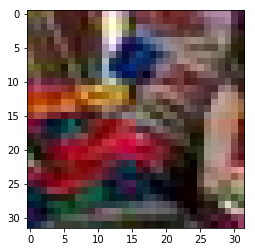

(399, 3, 64, 64)
(399, 3, 32, 32)


In [9]:


img_train_batch, center_train_batch, caps_train_batch = train_iter[100:500]
print img_train_batch.shape
print center_train_batch.shape

idx = 0
plt.imshow(img_train_batch[idx])
plt.show()
plt.imshow(center_train_batch[idx])
plt.show()

img_train_batch = np.transpose(img_train_batch,(0,3,1,2))
center_train_batch= np.transpose(center_train_batch, (0,3,1,2))
print img_train_batch.shape
print center_train_batch.shape


#print caps_train_batch.shape

In [10]:
# def show_true_fake(true_imgs, subset = 1):
#     for i in range(subset):
#         idx = np.random.randint(true_imgs.shape[0])
#         fake_imgs = get_imgs(true_imgs[idx:idx+1])
        
#         image = np.transpose(true_imgs[idx], (1,2,0))
#         fake_one = np.transpose(fake_imgs[0], (1,2,0))
#         plt.imshow(image)
#         plt.figure()
#         plt.imshow(fake_one)
#         plt.figure()
#         plt.show()



In [10]:
# def show_images(images, subset = 1, transpose=True):
#     for i in range(subset):
#         idx = np.random.randint(images.shape[0])
#         image = np.transpose(images[idx], (1,2,0))
#         plt.imshow(image)
#         plt.figure()
#         plt.show()
    

In [9]:
def show_true_fake(batch, subset = 1):
    inputs, targets, caps = batch #inputs and targets already transposed
    
    for i in range(subset):
        idx = np.random.randint(inputs.shape[0])
        fake_imgs = get_imgs(inputs[idx:idx+1])
        
        target_img = np.transpose(targets[idx], (1,2,0))
        fake_one = np.transpose(fake_imgs[0], (1,2,0))
        
#         plt.imshow(contour)
        plt.imshow(target_img)
        plt.figure()
        plt.imshow(fake_one)
        plt.figure()
        plt.show()



In [10]:
inputs, targets, caps = train_iter[:500]
        
inputs = np.transpose(inputs,(0,3,1,2))
targets= np.transpose(targets, (0,3,1,2))
batch = inputs, targets, caps

     minibatch  0  cost :  0.00779580883682


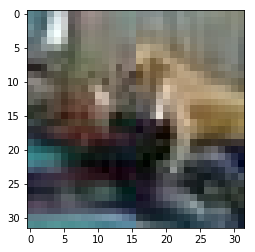

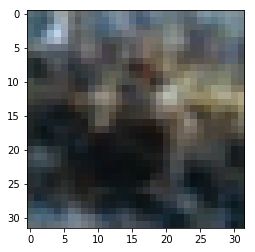

cost at epoch  0  =  0.00779580883682
--------------------------------------------


In [28]:
num_epochs = 1
for ep in range(num_epochs):
    cost_epoch = 0
    for i in range(1):#, batch in enumerate(train_iter):

        #inputs, targets, caps = batch
        
        
        
        cost_minibatch = ae_train_fn(inputs, targets)
        print "     minibatch ", i, " cost : ", cost_minibatch
        cost_epoch += cost_minibatch
        if num_epochs<=1:
             show_true_fake(batch)
        
    print 'cost at epoch ', ep, ' = ', cost_epoch
    
    

    print '--------------------------------------------'
            

In [ ]:
inputs_v, targets_v, caps_v = train_iter[:500]
        
inputs = np.transpose(inputs,(0,3,1,2))
targets= np.transpose(targets, (0,3,1,2))
batch = inputs, targets, caps

cost 0  =  0.00409850804135


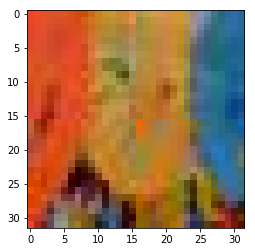

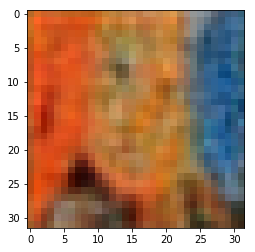

--------------------------------------------
cost 1  =  0.00411602994427


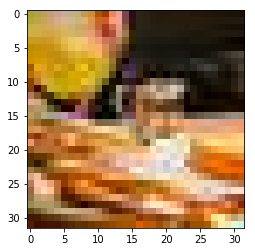

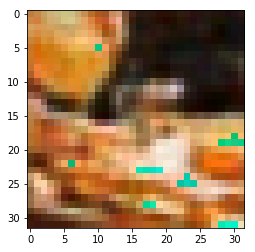

--------------------------------------------
cost 2  =  0.00415697321296


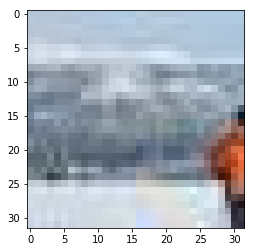

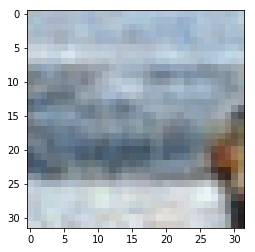

--------------------------------------------
cost 3  =  0.00425629178062


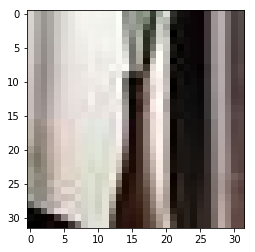

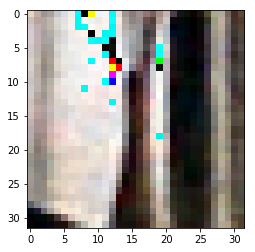

--------------------------------------------
cost 4  =  0.00424823211506


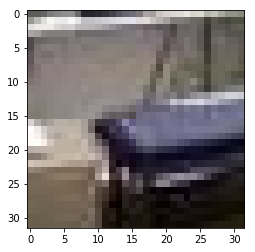

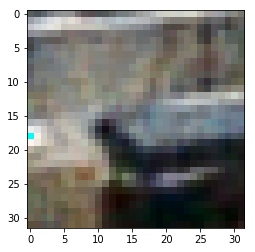

--------------------------------------------
cost 5  =  0.00426181172952


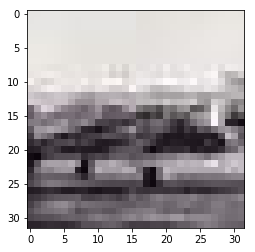

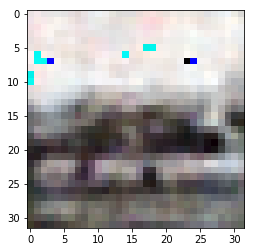

--------------------------------------------
cost 6  =  0.00412066606805


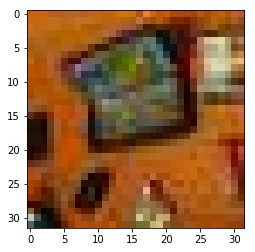

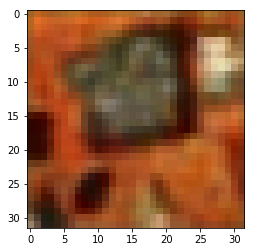

--------------------------------------------
cost 7  =  0.00401569716632


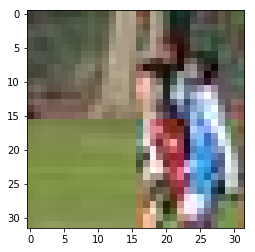

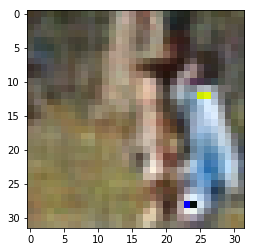

--------------------------------------------
cost 8  =  0.00393821625039


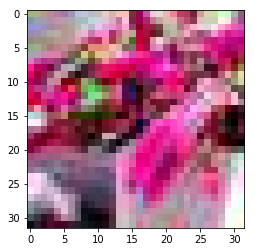

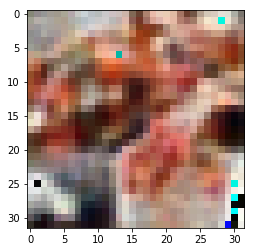

--------------------------------------------
cost 9  =  0.00390378409065


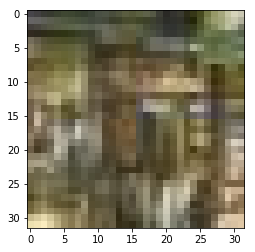

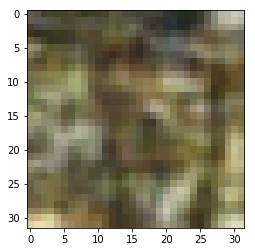

--------------------------------------------


In [21]:
num_epochs = 10
for i in range(num_epochs):
    
    cost = ae_train_fn(center_train_batch)
    print 'cost', i, ' = ', cost
    
    if num_epochs<=10:
        show_true_fake(center_train_batch)

    print '--------------------------------------------'
            

In [12]:
batch[2].shape

AttributeError: 'tuple' object has no attribute 'shape'

In [29]:
img_train_batch.shape

(126L, 64L, 64L, 3L)

In [28]:
img_train_batch.shape

(10, 3, 64, 64)

In [29]:
center_train_batch[0].shape

(3, 32, 32)

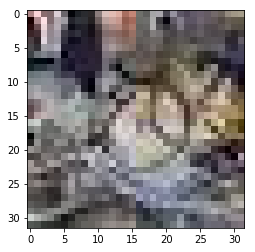

In [32]:

image_reshape = np.transpose(center_train_batch[0],(1,2,0))
imshow(image_reshape)

In [33]:
img_train, center_train, caps_train = train_iter[:50]

/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


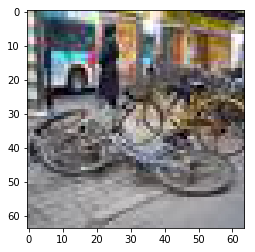

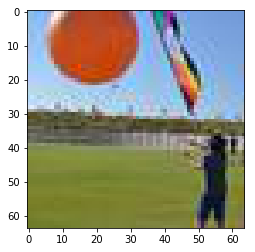

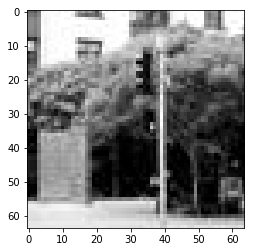

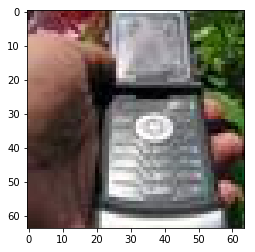

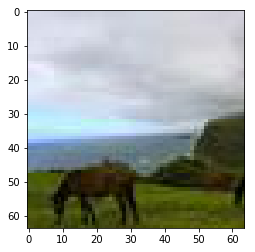

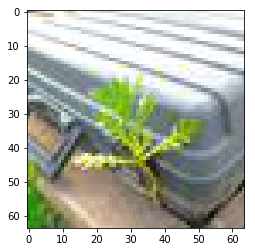

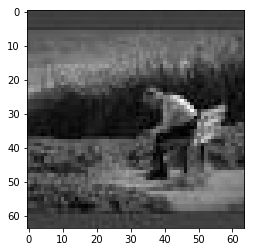

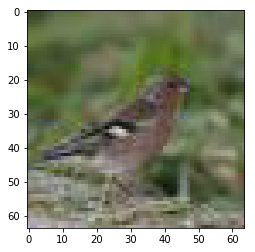

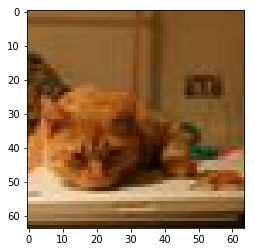

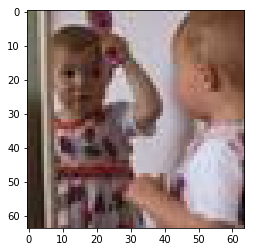

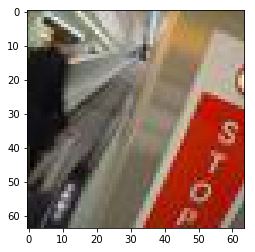

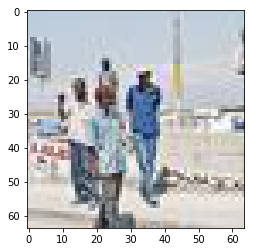

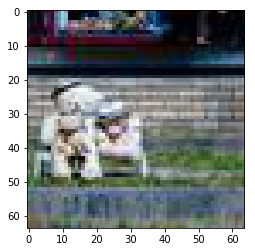

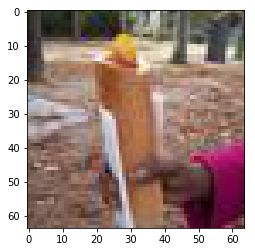

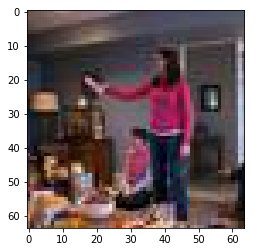

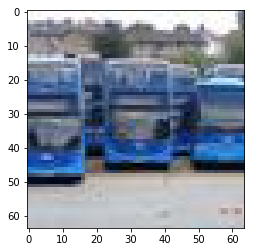

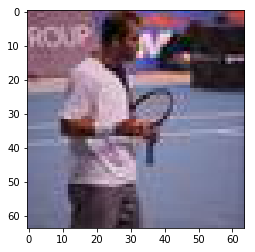

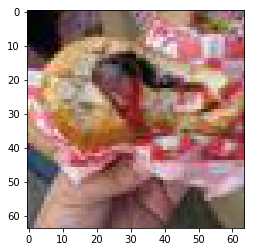

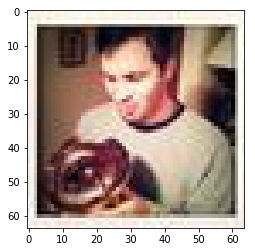

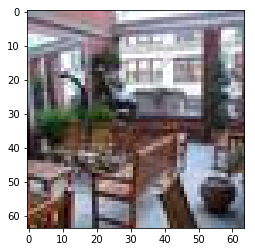

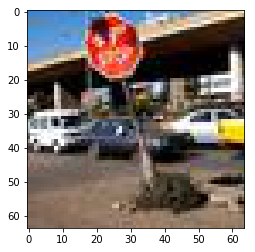

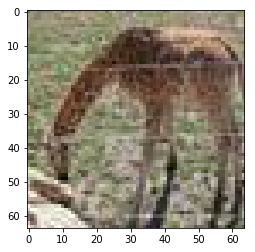

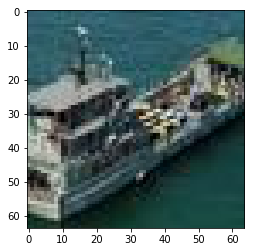

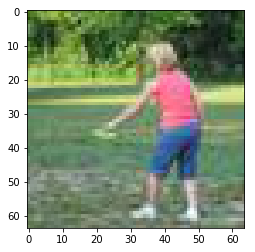

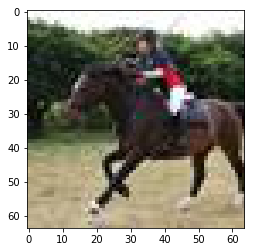

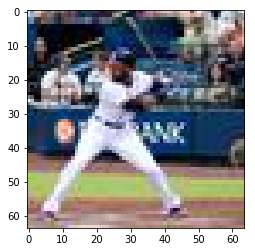

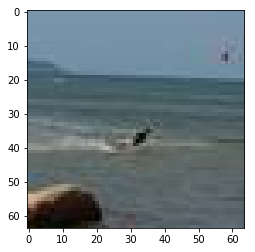

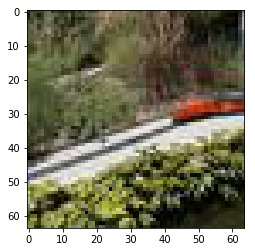

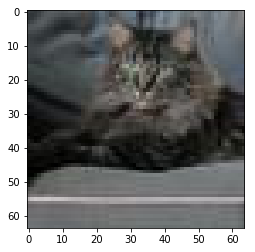

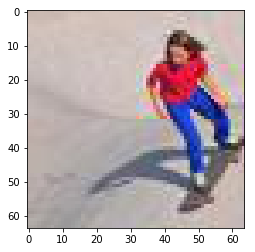

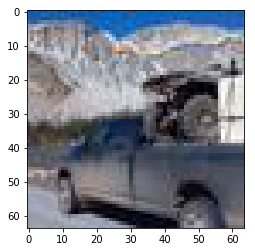

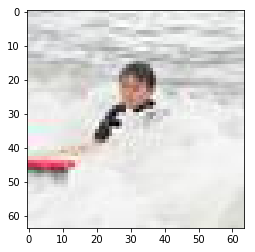

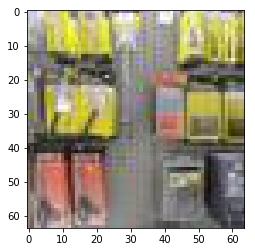

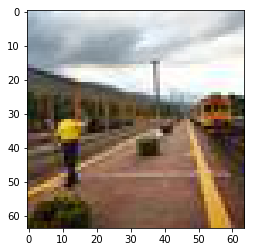

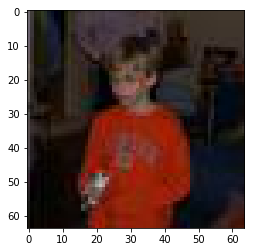

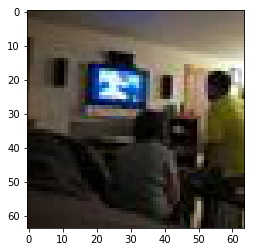

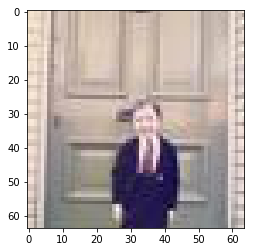

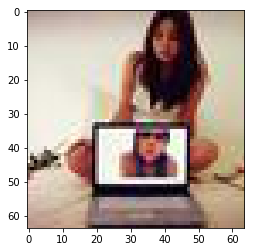

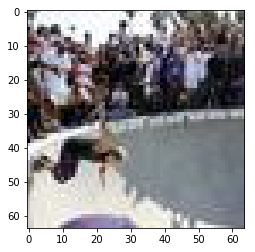

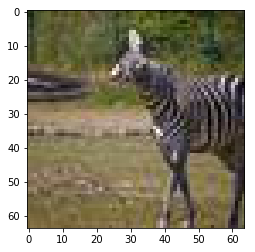

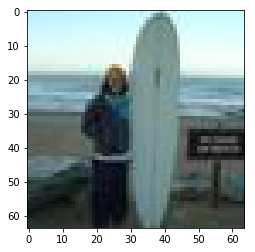

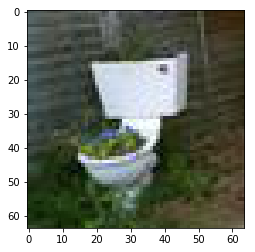

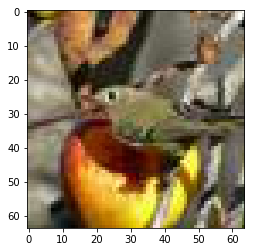

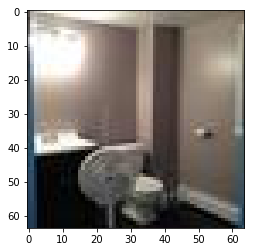

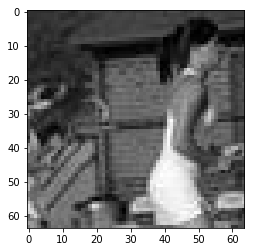

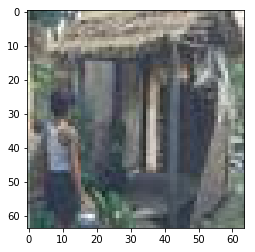

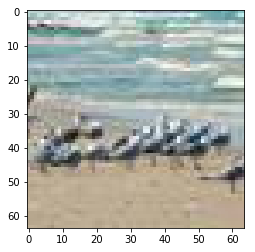

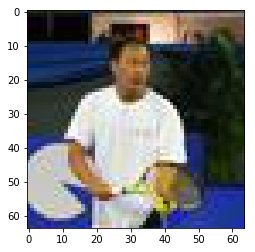

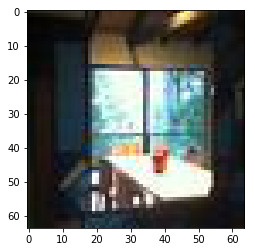

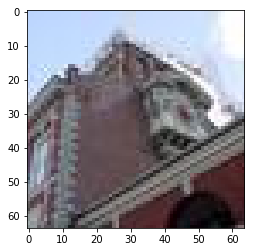

In [37]:
for i in range(50):
    plt.imshow(img_train[i])
    plt.figure()
    

In [35]:
img_train.shape

(50, 64, 64, 3)

In [36]:
img_train[3].shape

(64, 64, 3)

In [38]:
G_input_noise = np.random.rand(img_train_batch.shape[0],n_filters*8,4,4)